In [1]:
import numpy as np

In [2]:
def analytical_solution(x,t, a,b,c):
    return np.exp((c-a)*t) * np.sin(x + b*t)

In [3]:
def Ψ(x):
    return np.sin(x)
def φL(t, a,b,c):
    return np.exp((c-a)*t) * (np.cos(b*t) + np.sin(b*t))
def φR(t, a,b,c):
    return -np.exp((c-a)*t) * (np.cos(b*t) + np.sin(b*t))

In [4]:
def tk(k, τ):
    return k * τ
def xi(L, i, h):
    return L + i*h

In [5]:
# N - кол-во слоёв по x
# K - кол-во слоёв по y
# T - max t [0:T]
# L, R - границы по x

def explicit_sol(L, R, N, T, K, a, b, c, approx="2p O(h)"):
    h = (R - L) / N
    τ = T / K
    sigma = (τ*a) / (h**2)
 
    u = np.zeros((K+1, N+1), dtype=np.float128)

    if (τ*a) / h**2 > 0.5:
        raise ValueError(f"τ = {τ}, h = {h}, sigma = {sigma} > 0.5")

    for k in range(K):
        if k == 0:
            for i in range(N+1):
                u[0, i] = Ψ(xi(L, i, h))
        else:
            for i in range(1,N):
                u[k,i] = (
                    u[k-1,i] * (1 - 2*sigma + τ*c) + 
                    u[k-1,i-1] * (sigma - (τ*b) / (2*h)) +
                    u[k-1,i+1] * (sigma + (τ*b) / (2*h))
                )
            if approx == "2p O(h)":
                u[k,0] = (h * φL(tk(k,τ), a,b,c) - u[k,1]) / (h-1)
                u[k,N] = (h * φR(tk(k,τ), a,b,c) + u[k, N-1]) / (h+1)
            elif approx == "3p O(h^2)":
                u[k,0] = (2*h * φL(tk(k,τ), a,b,c) - 4*u[k,1] + u[k,2]) / (2*h-3)
                u[k,N] = (2*h * φR(tk(k,τ), a,b,c) + 4*u[k,N-1] - u[k,N-2]) / (2*h + 3)
            elif approx == "2p O(h^2)":
                u[k,0] = (
                        u[k,1] - h * φL(tk(k,τ), a,b,c) + (h**2 / (2*a*τ)) * u[k-1,0] + (b*h**2 / (2*a)) * φL(tk(k,τ), a,b,c)
                    ) / (
                        1 - h + (h**2 / (2*a*τ)) + (b*h**2 / (2*a)) - (c*h**2 / (2*a))
                )
                
                u[k,-1] = (
                        u[k,-2] + h * φR(tk(k,τ), a,b,c) + (h**2 / (2 * a * τ)) * u[k-1,-1] + (b * h**2 / (2 * a)) * φR(tk(k,τ), a,b,c)
                    ) / (
                        1 + h + (h**2 / (2 * a * τ)) + (b * h**2 / (2 * a)) - (c * h**2 / (2 * a))
                )
                
    return u


In [6]:
def tdma(a: np.array, b: np.array, c: np.array, d: np.array) -> np.array:
    n = len(d)
    p = np.zeros(n)
    q = np.zeros(n)

    p[0] = -c[0] / b[0]
    q[0] = d[0] / b[0]

    for i in range(1, n-1):
        p[i] = -c[i] / (b[i] + a[i]*p[i-1])
        q[i] = (d[i] - a[i]*q[i-1]) / (b[i] + a[i]*p[i-1])
    
    p[-1] = 0
    q[-1] = (d[n-1] - a[n-1]*q[n-2]) / (b[n-1] + a[n-1]*p[n-2])
    
    x = np.zeros(n)
    x[-1] = q[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = p[i] * x[i+1] + q[i]
    return x

In [ ]:
def implicit_sol(L, R, N, T, K, a, b, c, approx="2p O(h)"):
    h = (R - L) / N
    τ = T / K
    sigma = (τ*a) / (h**2)
 
    u = np.zeros((K+1, N+1), dtype=np.float128)
    a_ = np.zeros(N+1, dtype=np.float128)
    b_ = np.zeros(N+1, dtype=np.float128)
    c_ = np.zeros(N+1, dtype=np.float128)
    d_ = np.zeros(N+1, dtype=np.float128)

    for i in range(N+1):
        u[0, i] = Ψ(xi(L, i, h))
    for k in range(K):
        for i in range(1,N):
            a_[i] = sigma - (b*τ) / (2*h)
            b_[i] = -1 - 2*sigma + c*τ
            c_[i] = sigma + (b*τ) / (2*h)
            d_[i] = -u[k,i]
        if approx == "2p O(h)":
            a_[0] = 0
            b_[0] = h - 1
            c_[0] = 1
            d_[0] = h * φL(tk(k+1,τ), a,b,c)

            a_[N] = -1
            b_[N] = h + 1
            c_[N] = 0
            d_[N] = h * φR(tk(k+1,τ), a,b,c)
        elif approx == "3p O(h^2)":
            a_[0] = 0
            b_[0] = -3 + 2*h + a_[1]/c_[1]
            c_[0] = 4 + b_[1]/c_[1]
            d_[0] = 2*h * φL(tk(k+1,τ), a,b,c) - u[k,1]/c_[1]

            a_[-1] = -4 - b_[-2]/a_[-2]
            b_[-1] = 3 + 2*h - c_[-2]/a_[-2]
            c_[-1] = 0
            d_[-1] = 2*h * φR(tk(k+1,τ), a,b,c) + u[k,-2]/a_[-2]
        elif approx == "2p O(h^2)":
            a_[0] = 0
            b_[0] = 2*a/h + h/τ - c*h - (2*a - b*h)
            c_[0] = -2*a/h
            d_[0] = (h/τ) * u[k,0] - φL(tk(k+1,τ), a,b,c) * (2*a - b*h)

            a_[-1] = -2*a/h
            b_[-1] = 2*a/h + h/τ - c*h + (2*a + b*h)
            c_[-1] = 0
            d_[-1] = (h/τ) * u[k,-1] + φR(tk(k+1,τ), a,b,c) * (2*a + b*h)

        
        res = tdma(a_,b_,c_,d_)

        for i in range(N+1):
            u[k+1,i] = res[i]
    
    return u


In [8]:
def crank_nicolson(L, R, N, T, K, a, b, c, approx="2p O(h)"):
    h = (R - L) / N
    τ = T / K
    sigma = (τ*a) / (h**2)
 
    u = np.zeros((K+1, N+1), dtype=np.float128)
    a_ = np.zeros(N+1, dtype=np.float128)
    b_ = np.zeros(N+1, dtype=np.float128)
    c_ = np.zeros(N+1, dtype=np.float128)
    d_ = np.zeros(N+1, dtype=np.float128)

    for i in range(N+1):
        u[0, i] = Ψ(xi(L, i, h))
    for k in range(K):
        for i in range(1,N):
            a_[i] = -(a*0.5/h**2 - b*0.5/(2*h))
            b_[i] = 1/τ + a/h**2 - c*0.5
            c_[i] = -(a*0.5/h**2 + b*0.5/(2*h))
            d_[i] = (
                (1/τ) * u[k,i] + 0.5*(a * (u[k,i+1] -2*u[k,i] + u[k,i-1]) / (h**2) +
                b * (u[k,i+1] - u[k,i-1]) / (2*h) + c*u[k,i])
            )
        if approx == "2p O(h)":
            a_[0] = 0
            b_[0] = h - 1
            c_[0] = 1
            d_[0] = h * φL(tk(k+1,τ), a,b,c)

            a_[N] = -1
            b_[N] = h + 1
            c_[N] = 0
            d_[N] = h * φR(tk(k+1,τ), a,b,c)
        elif approx == "3p O(h^2)":
            q = (b*τ) / (2*h)

            a_[0] = 0
            b_[0] = -3 + 2*h + (sigma - q) / (sigma + q)
            c_[0] = 4 + (-1 - 2*sigma + c*τ) / (sigma + q)
            d_[0] = 2*h * φL(tk(k+1,τ), a,b,c) - u[k,1] / (sigma + q)

            a_[-1] = -4 - (-1 - 2*sigma + c*τ) / (sigma - q)
            b_[-1] = 3 + 2*h - (sigma + q) / (sigma - q)
            c_[-1] = 0
            d_[-1] = 2*h * φR(tk(k+1,τ), a,b,c) + u[k,-2] / (sigma - q)
        elif approx == "2p O(h^2)":
            a_[0] = 0
            b_[0] = 2*a/h + h/τ - c*h - (2*a - b*h)
            c_[0] = -2*a/h
            d_[0] = (h/τ) * u[k,0] - φL(tk(k+1,τ), a,b,c) * (2*a - b*h)

            a_[-1] = -2*a/h
            b_[-1] = 2*a/h + h/τ - c*h + (2*a + b*h)
            c_[-1] = 0
            d_[-1] = (h/τ) * u[k,-1] + φR(tk(k+1,τ), a,b,c) * (2*a + b*h)

        
        res = tdma(a_,b_,c_,d_)

        for i in range(N+1):
            u[k+1,i] = res[i]
    
    return u


In [9]:
L = 0
R = np.pi
N = 100
T = 10
K = 50000
a = 1
b = 10
c = -10

h = (R - L) / N
τ = T / K

u_ex1 = explicit_sol(L, R, N, T, K, a, b, c, "2p O(h)")
u_ex2 = explicit_sol(L, R, N, T, K, a, b, c, "3p O(h^2)")
u_ex3 = explicit_sol(L, R, N, T, K, a, b, c, "2p O(h^2)")

u_im1 = implicit_sol(L, R, N, T, K, a, b, c, "2p O(h)")
u_im2 = implicit_sol(L, R, N, T, K, a, b, c, "3p O(h^2)")
u_im3 = implicit_sol(L, R, N, T, K, a, b, c, "2p O(h^2)")

u_cn1 = crank_nicolson(L, R, N, T, K, a, b, c, "2p O(h)")
u_cn2 = crank_nicolson(L, R, N, T, K, a, b, c, "3p O(h^2)")
u_cn3 = crank_nicolson(L, R, N, T, K, a, b, c, "2p O(h^2)")


In [10]:
ti = 24
tt = tk(ti, τ)
xx = np.linspace(L, R, N + 1)
y_true = np.array([analytical_solution(x,tt,a,b,c) for x in xx])

y_ex1 = u_ex1[ti]
y_ex2 = u_ex2[ti]
y_ex3 = u_ex3[ti]

y_im1 = u_im1[ti]
y_im2 = u_im2[ti]
y_im3 = u_im3[ti]

y_cn1 = u_cn1[ti]
y_cn2 = u_cn2[ti]
y_cn3 = u_cn3[ti]

# print(y_true)
# print(y_cn1)

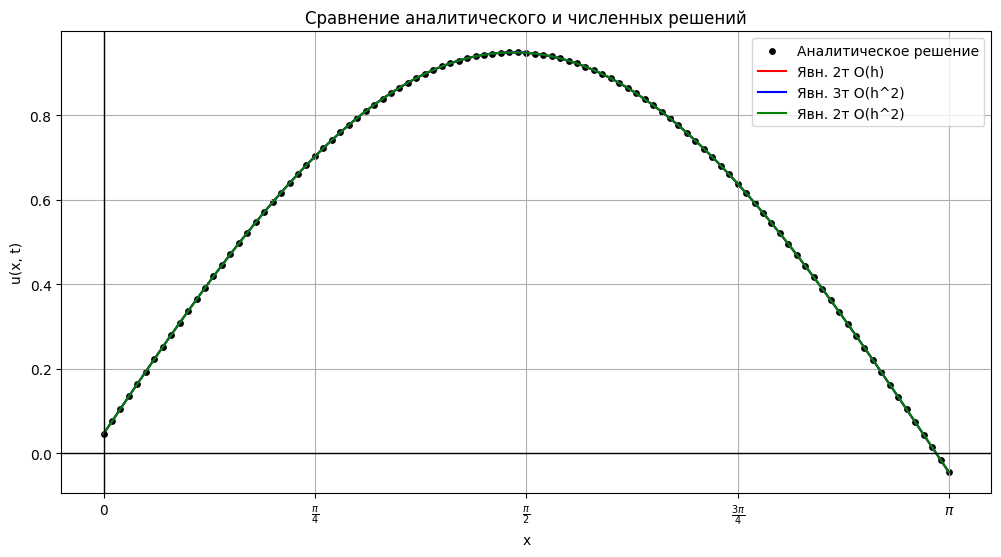

In [11]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))


plt.scatter(xx, y_true, s=15, color="black", label=f'Аналитическое решение')
plt.plot(xx, y_ex1, color="red", label=f'Явн. 2т O(h)')
plt.plot(xx, y_ex2, color="blue", label=f'Явн. 3т O(h^2)')
plt.plot(xx, y_ex3, color="green", label=f'Явн. 2т O(h^2)')


plt.title('Сравнение аналитического и численных решений')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.xticks(ticks=[0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
           labels=['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
# plt.ylim(-0.000025, 0.000025)

plt.grid()
plt.legend()
plt.show()

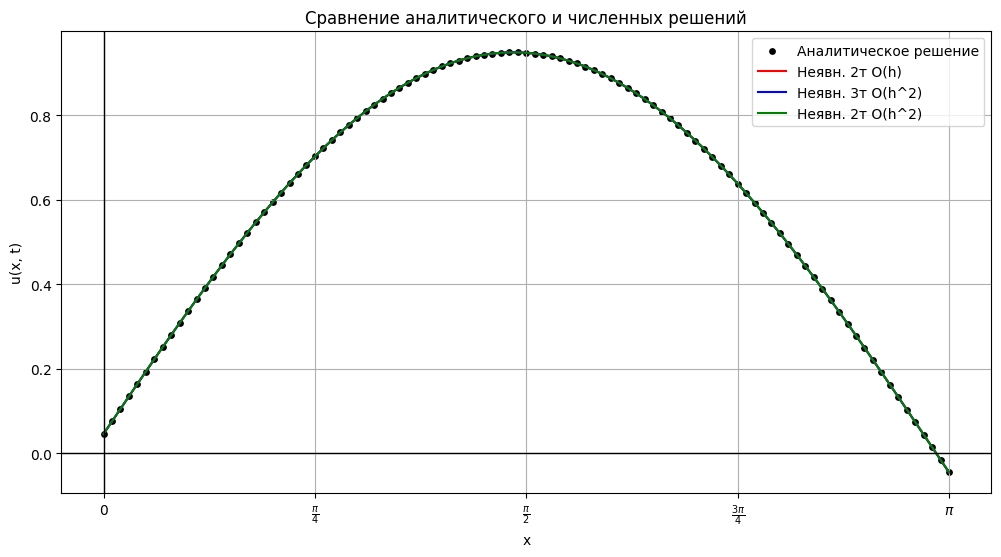

In [12]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))


plt.scatter(xx, y_true, s=15, color="black", label=f'Аналитическое решение')
plt.plot(xx, y_im1, color="red", label=f'Неявн. 2т O(h)')
plt.plot(xx, y_im2, color="blue", label=f'Неявн. 3т O(h^2)')
plt.plot(xx, y_im3, color="green", label=f'Неявн. 2т O(h^2)')


plt.title('Сравнение аналитического и численных решений')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.xticks(ticks=[0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
           labels=['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
# plt.ylim(-0.000025, 0.000025)

plt.grid()
plt.legend()
plt.show()

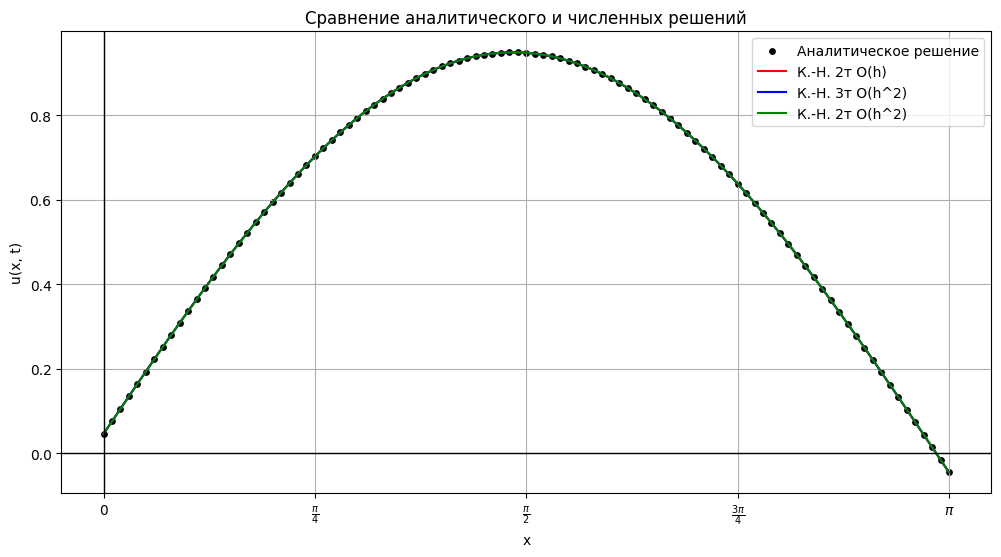

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))


plt.scatter(xx, y_true, s=15, color="black", label=f'Аналитическое решение')
plt.plot(xx, y_cn1, color="red", label=f'К.-Н. 2т O(h)')
plt.plot(xx, y_cn2, color="blue", label=f'К.-Н. 3т O(h^2)')
plt.plot(xx, y_cn3, color="green", label=f'К.-Н. 2т O(h^2)')


plt.title('Сравнение аналитического и численных решений')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.xticks(ticks=[0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
           labels=['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
# plt.ylim(-0.000025, 0.000025)

plt.grid()
plt.legend()
plt.show()

In [14]:
tt = np.linspace(0, T, K + 1)
mae_ex1 = np.zeros(K+1)
mae_ex2 = np.zeros(K+1)
mae_ex3 = np.zeros(K+1)

mae_im1 = np.zeros(K+1)
mae_im2 = np.zeros(K+1)
mae_im3 = np.zeros(K+1)

mae_cn1 = np.zeros(K+1)
mae_cn2 = np.zeros(K+1)
mae_cn3 = np.zeros(K+1)
for k in range(K+1):
    for i in range(N+1):
        res = analytical_solution(xi(L, i, h), tk(k, τ), a,b,c)
        mae_ex1[k] += np.abs(u_ex1[k,i] - res)
        mae_ex2[k] += np.abs(u_ex2[k,i] - res)
        mae_ex3[k] += np.abs(u_ex3[k,i] - res)

        mae_im1[k] += np.abs(u_im1[k,i] - res)
        mae_im2[k] += np.abs(u_im2[k,i] - res)
        mae_im3[k] += np.abs(u_im3[k,i] - res)

        mae_cn1[k] += np.abs(u_cn1[k,i] - res)
        mae_cn2[k] += np.abs(u_cn2[k,i] - res)
        mae_cn3[k] += np.abs(u_cn3[k,i] - res)


    mae_ex1[k] /= N
    mae_ex2[k] /= N
    mae_ex3[k] /= N
    
    mae_im1[k] /= N
    mae_im2[k] /= N
    mae_im3[k] /= N

    mae_cn1[k] /= N
    mae_cn2[k] /= N
    mae_cn3[k] /= N

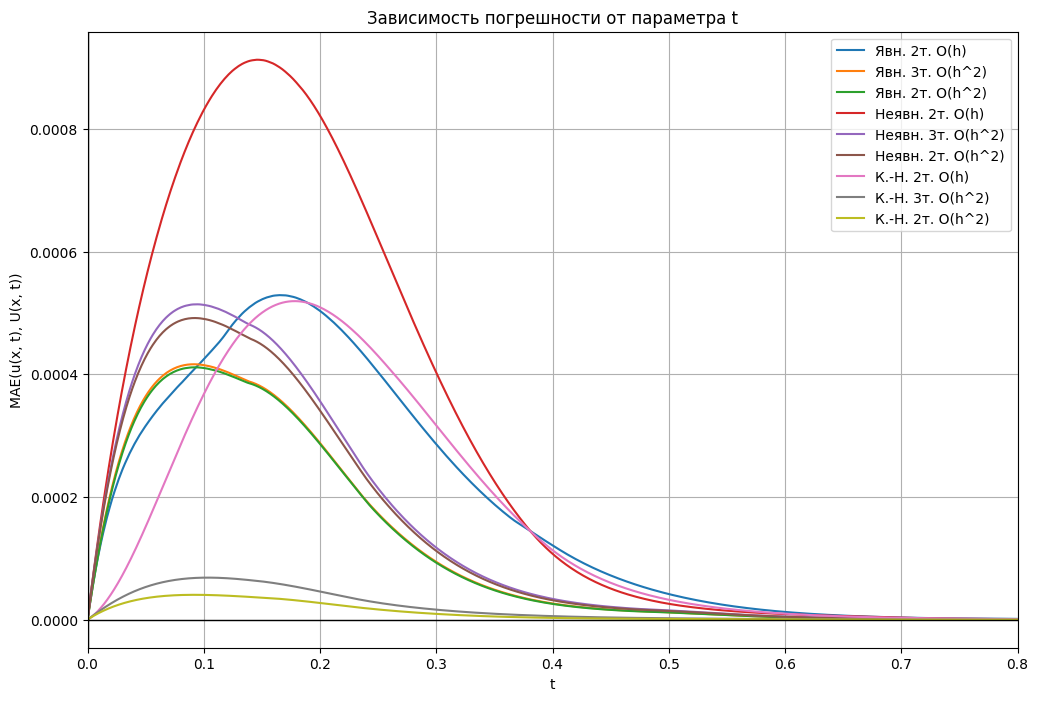

In [16]:

plt.figure(figsize=(12, 8))
plt.plot(tt, mae_ex1, label="Явн. 2т. O(h)")
plt.plot(tt, mae_ex2, label="Явн. 3т. O(h^2)")
plt.plot(tt, mae_ex3, label="Явн. 2т. O(h^2)")

plt.plot(tt, mae_im1, label="Неявн. 2т. O(h)")
plt.plot(tt, mae_im2, label="Неявн. 3т. O(h^2)")
plt.plot(tt, mae_im3, label="Неявн. 2т. O(h^2)")

plt.plot(tt, mae_cn1, label="К.-Н. 2т. O(h)")
plt.plot(tt, mae_cn2, label="К.-Н. 3т. O(h^2)")
plt.plot(tt, mae_cn3, label="К.-Н. 2т. O(h^2)")

plt.xlabel('t')
plt.ylabel('MAE(u(x, t), U(x, t))')
plt.title('Зависимость погрешности от параметра t')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.xlim(0, 0.8)

plt.legend()
plt.grid()
plt.show()